# Sentiment Analysis using Bidirectional-LSTM

## Importing Essential Libraries

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

import nltk

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb
# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers import Embedding
from keras.utils import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import os


In [8]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Configuration for visualization 

In [13]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

## Import Data

In [15]:
usecols = ['sentiment','review']
train_data = pd.read_csv(
    filepath_or_buffer='D:/Btech/mani/Sentiment Analysis/labeledTrainData.tsv.zip',usecols=usecols, sep='\t')

additional_data = pd.read_csv(
    filepath_or_buffer='D:/Btech/mani/Sentiment Analysis/IMDB Dataset.csv',encoding="latin-1")[usecols]
additional_data['sentiment'] = additional_data['sentiment'].map({"negative":0, "positive":1})

testData = pd.read_csv(
    filepath_or_buffer="D:/Btech/mani/Sentiment Analysis/testData.tsv.zip",
    sep='\t')

unlabeled_data = pd.read_csv(
    filepath_or_buffer="D:/Btech/mani/Sentiment Analysis/unlabeledTrainData.tsv.zip", 
    error_bad_lines=False,
    sep='\t')


b'Skipping line 43043: expected 2 fields, saw 3\n'


In [16]:
datasets = [train_data, additional_data, testData, unlabeled_data]
titles = ['Train data', 'additional_data','Submission data', 'Unlabeled train data']
for dataset, title in zip(datasets,titles):
    print(title)
    dataset.info()
    display(dataset.head())

Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  int64 
 1   review     25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


additional_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  50000 non-null  int64 
 1   review     50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


,sentiment,review
0,1,One of the other reviewers has mentioned that ...
1,1,A wonderful little production. <br /><br />The...
2,1,I thought this was a wonderful way to spend ti...
3,0,Basically there's a family where a little boy ...
4,1,"Petter Mattei's ""Love in the Time of Money"" is..."


Submission data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   review  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


Unlabeled train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      49998 non-null  object
 1   review  49998 non-null  object
dtypes: object(2)
memory usage: 781.3+ KB


,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."


In [17]:
all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)
print('Total number of reviews:', len(all_reviews))
train_data.info()

Total number of reviews: 149998
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  int64 
 1   review     25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [18]:
train_data = pd.concat((train_data, additional_data[additional_data.sentiment != -1]),
                       axis=0, ignore_index=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75000 non-null  int64 
 1   review     75000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


## Checking Class Balance 

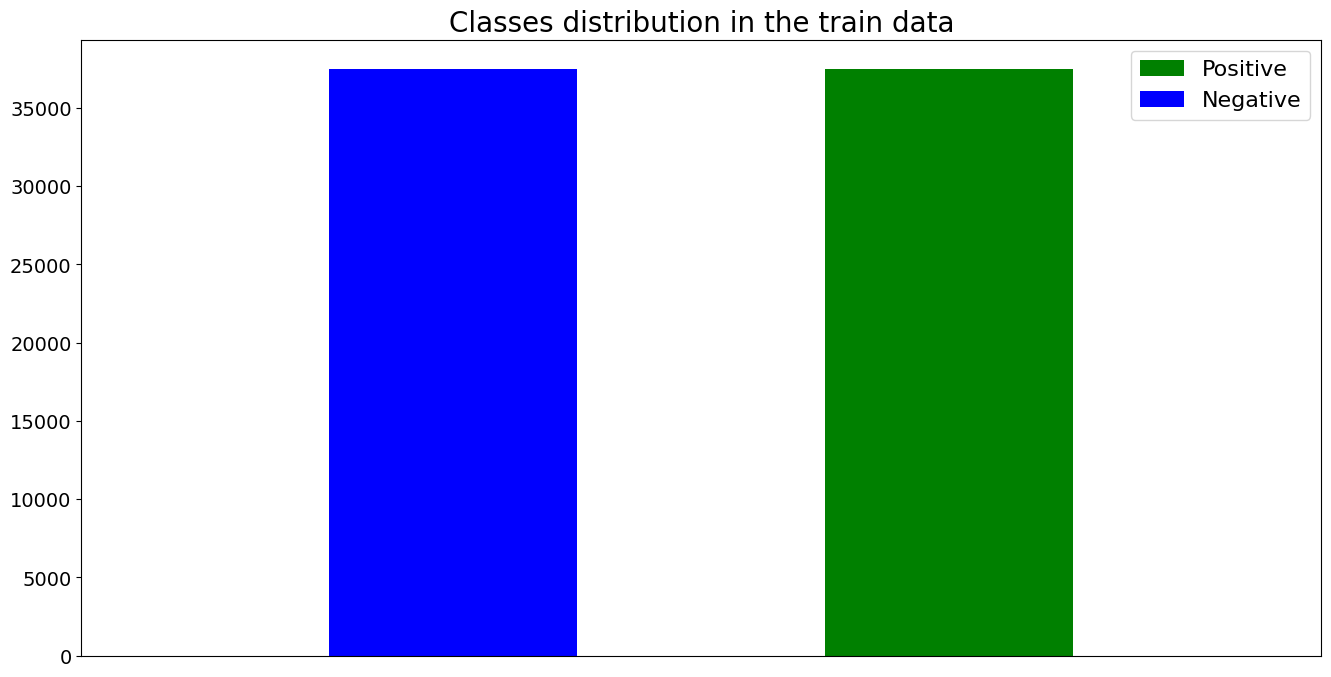

In [19]:
plt.hist(train_data[train_data.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(train_data[train_data.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [27]:
import re

## Preprocessing Data

In [35]:
def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "html.parser").get_text()
    # 2. Remove non-letters
    letters_only = re.sub(r'[^\w\s]', '', review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = review.split()
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amans\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [36]:
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

In [25]:
pip install lxml

     ---------------------------------------- 3.9/3.9 MB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amans\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [38]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amans\AppData\Roaming\nltk_data...


True

In [39]:

all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0

## Spliting Training and Test data from the combined reviews data

In [40]:
X_train_data = all_reviews[:train_data.shape[0]]
Y_train_data = train_data.sentiment.values
X_submission = all_reviews[75000: 100000]


## Graphical representation for the train data distribution

In [41]:
train_data['review_lenght'] = np.array(list(map(len, X_train_data)))
median = train_data['review_lenght'].median()
mean = train_data['review_lenght'].mean()
mode = train_data['review_lenght'].mode()[0]

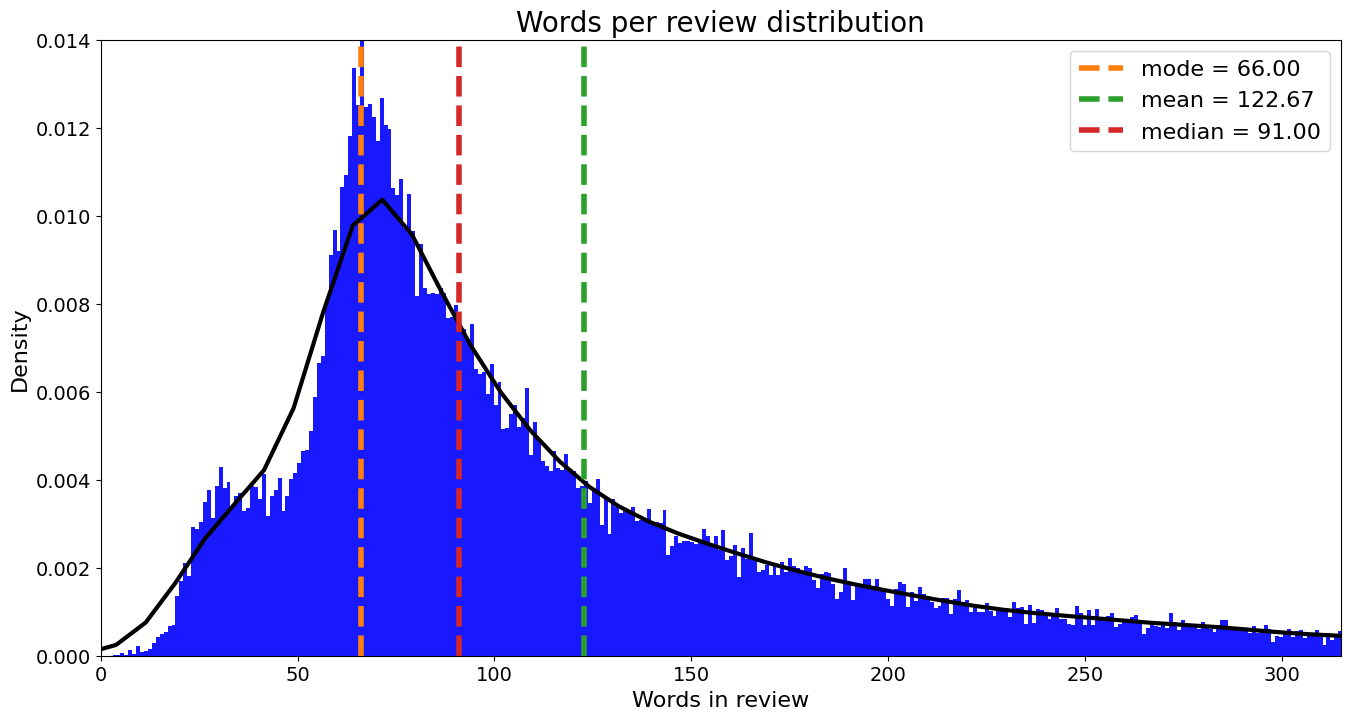

In [42]:
fig, ax = plt.subplots()
sb.distplot(train_data['review_lenght'], bins=train_data['review_lenght'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_data['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()

## Now using gensim's phrases to find bigrams or trigrams

In [43]:
%%time
bigrams = Phrases(sentences=all_reviews)

Wall time: 40.8 s


In [44]:
%%time
trigrams = Phrases(sentences=bigrams[all_reviews])

Wall time: 2min


In [45]:
print(bigrams['space station near the solar system'.split()])

['space_station', 'near', 'the', 'solar_system']


In [46]:
%%time
embedding_vector_size = 256
trigrams_model = Word2Vec(sentences = trigrams[bigrams[all_reviews]],
                          vector_size  = embedding_vector_size,
                          min_count=3, window=5, workers=4)

Wall time: 12min 3s


In [47]:
print("Vocabulary size:", len(trigrams_model.wv.key_to_index))

Vocabulary size: 152077


And now we can use gensim's word2vec model to build a word embedding. Also we can use the word2vec model to define most similar words, calculate diffence between the words, etc.

In [48]:
trigrams_model.wv.most_similar('galaxy')

[('planet', 0.7402178645133972),
 ('portal', 0.738618016242981),
 ('continent', 0.7350394129753113),
 ('wormhole', 0.7304971814155579),
 ('colony', 0.7281989455223083),
 ('antarctica', 0.7258850932121277),
 ('outpost', 0.7211799621582031),
 ('vessel', 0.7194694876670837),
 ('orbit', 0.7183752059936523),
 ('solar_system', 0.715196430683136)]

In [49]:
trigrams_model.wv.doesnt_match(['galaxy', 'starship', 'planet', 'dog'])

'dog'

In [50]:
%%time
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab)#.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(sequences=vectorize_data(X_data, vocab=trigrams_model.wv.key_to_index),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
Wall time: 39min 3s


## splitting data into training and validation datasets

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, Y_train_data,  test_size=0.10,  shuffle=True, random_state=42)

# Configuring Bidirectional LSTM model

In [52]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 256)          38931712  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              394240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [53]:
model.compile(loss="binary_crossentropy",  optimizer='adam',  metrics=['accuracy'])

history = model.fit(x=X_train,  y=y_train,  validation_data=(X_test, y_test),  batch_size=100,   epochs=10)

Epoch 1/10
675/675 [==============================] - 2130s 3s/step - loss: 0.3434 - accuracy: 0.8547 - val_loss: 0.2742 - val_accuracy: 0.8841
Epoch 2/10
675/675 [==============================] - 2314s 3s/step - loss: 0.2505 - accuracy: 0.8996 - val_loss: 0.2389 - val_accuracy: 0.9033
Epoch 3/10
675/675 [==============================] - 2331s 3s/step - loss: 0.1975 - accuracy: 0.9237 - val_loss: 0.2268 - val_accuracy: 0.9069
Epoch 4/10
675/675 [==============================] - 2349s 3s/step - loss: 0.1530 - accuracy: 0.9417 - val_loss: 0.1955 - val_accuracy: 0.9261
Epoch 5/10
675/675 [==============================] - 2357s 3s/step - loss: 0.1084 - accuracy: 0.9607 - val_loss: 0.1844 - val_accuracy: 0.9353
Epoch 6/10
675/675 [==============================] - 2360s 3s/step - loss: 0.0722 - accuracy: 0.9743 - val_loss: 0.1816 - val_accuracy: 0.9475
Epoch 7/10
675/675 [==============================] - 4787s 7s/step - loss: 0.0564 - accuracy: 0.9798 - val_loss: 0.1797 - val_accuracy:

## Confusion matrix

In [54]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,  normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [55]:
%%time
prediction_train = model.predict(X_train)
# Get labels based on probability 1 if p>= 0.5 else 0
y_train_pred = []
for i in prediction_train:
    if i >= 0.5:
        y_train_pred.append(1)
    else:
        y_train_pred.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(y_train, y_train_pred))

prediction_test = model.predict(X_test)
# Get labels based on probability 1 if p>= 0.5 else 0
y_test_pred = []
for i in prediction_test:
    if i >= 0.5:
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(y_test, y_test_pred))


#y_train_pred = model.predict(X_train)# > 0.5).astype("int32")
#y_test_pred = model.predict(X_test) #> 0.5).astype("int32")
#y_train_pred = np.argmax(model.predict(X_train), axis=-1)
#y_test_pred = np.argmax(model.predict(X_test), axis=-1)

2110/2110 [==============================] - 794s 376ms/step
Accuracy of prediction on test set :  0.9980740740740741
235/235 [==============================] - 87s 370ms/step
Accuracy of prediction on test set :  0.9534666666666667
Wall time: 14min 42s


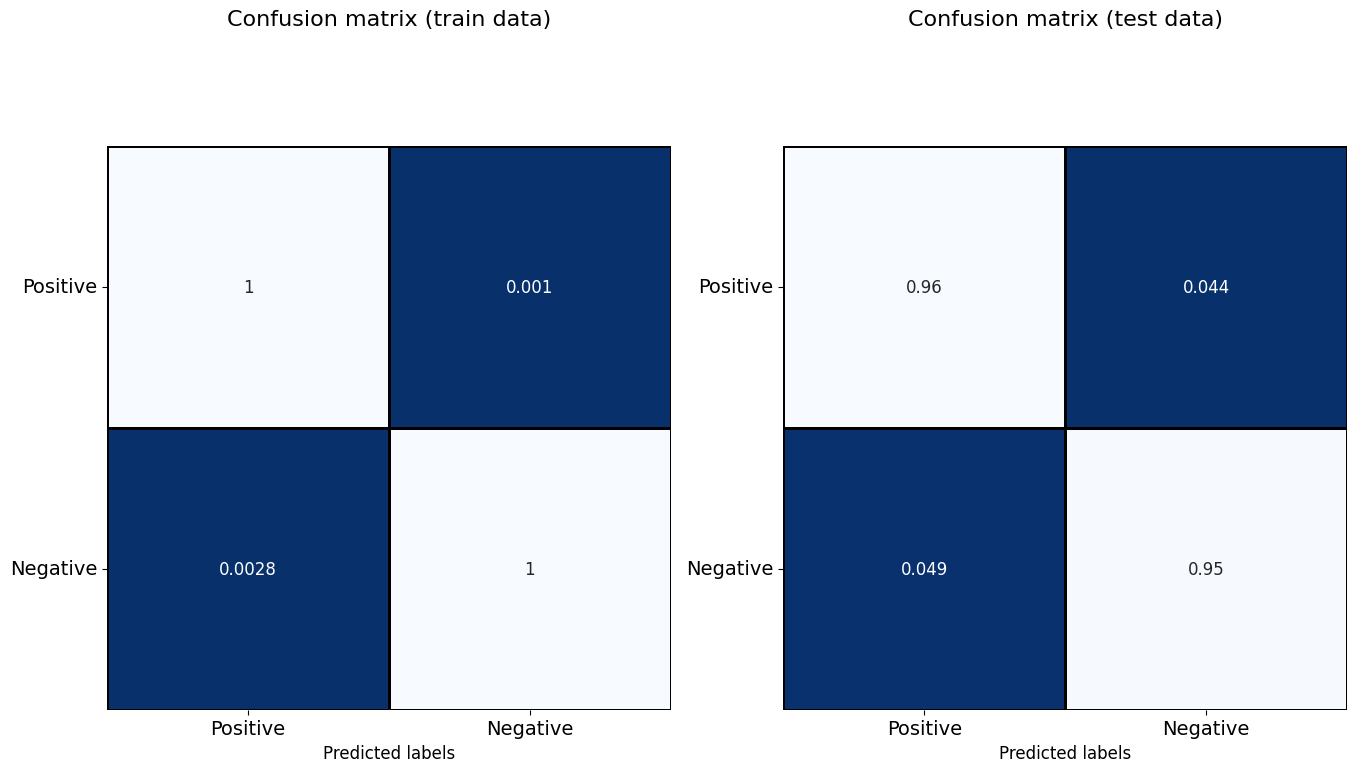

In [56]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

## Plotting Model accuracy and Model loss

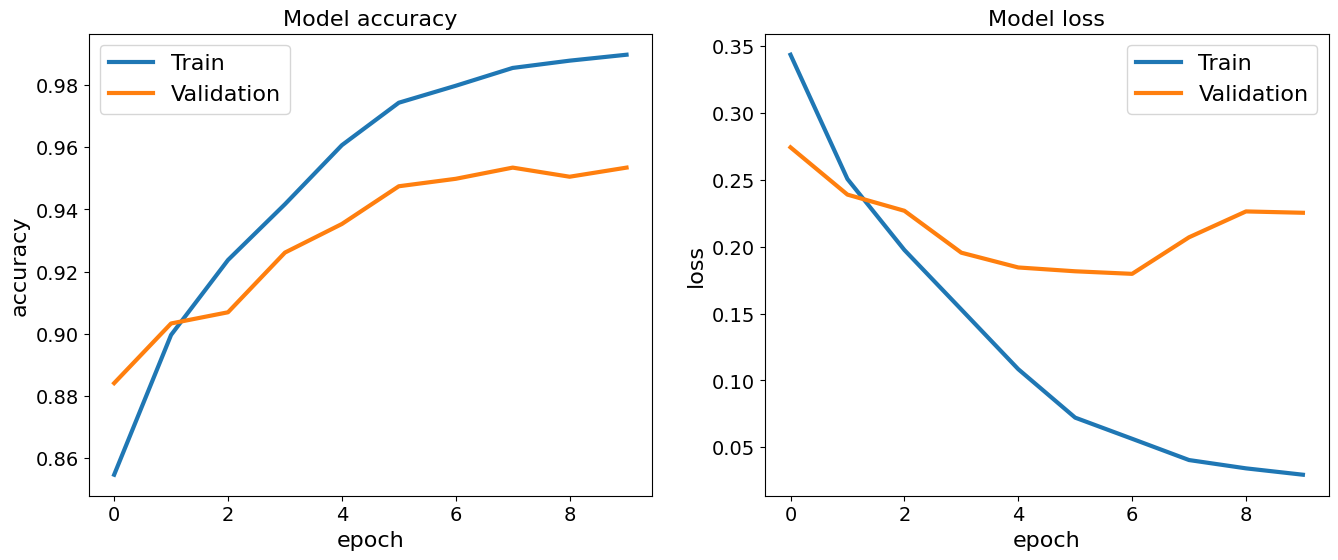

In [57]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

## Now preprocessing Test data to make predictions by passing through trained model 

In [58]:
print('Convert sentences to sentences with ngrams...', end='\r')
X_submit = trigrams[bigrams[X_submission]]
print('Convert sentences to sentences with ngrams... (done)')
X_sub = pad_sequences(sequences=vectorize_data(X_submit, vocab=trigrams_model.wv.key_to_index),
                      maxlen=input_length,
                      padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)


In [59]:
%%time
prediction_test = model.predict(X_sub)
# Get labels based on probability 1 if p>= 0.5 else 0
y_train_pred = []
for i in prediction_test:
    if i >= 0.5:
        y_train_pred.append(1)
    else:
        y_train_pred.append(0)

#Y_sub_pred = np.argmax(model.predict(X_sub), axis=-1)
#Y_sub_pred = model.predict_classes(X_sub)

782/782 [==============================] - 295s 378ms/step
Wall time: 4min 56s
